# The Battle of Neighborhoods

The objective of this project is to find the best location to open a new business like restaurants, hotels, gym and so on in Barueri, Brazil. This report can be used by investors.

The Foursquare API is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analysing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the k-means clustering algorithm is used to achieve the task. The optimal number of clusters can be obtained using silhouette score. Folium visualization library can be used to visualize the clusters superimposed on the map of Chennai city. These clusters can be analyzed to help small scale business owners select a suitable location for their need such as Hotels, Shopping Malls, Restaurants or even specifically Indian restaurants or Coffee shops.

#### Install libraries

In [ ]:
!pip install geopy
!pip install folium

#### Import libraries

In [1]:
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('All Done!')

All Done!


### Data Requirements 

We will use the following pdf file as our dataset: https://www.anatel.gov.br/Portal/verificaDocumentos/documento.asp?numeroPublicacao=285354&assuntoPublicacao=Rela

To use this file as data, I converted it in a Excel file. Some adjustments were done to use the file to the entire state instead only for cities.

In [2]:
df = pd.read_excel(r'C:\Users\William Roesch\Downloads\BairrosSP.xlsx')
df.head()

,NOME CF,SIGLA CF,ENDEREÇO,MUNICÍPIO,LATITUDE DEG,LATITUDE DEC,LONGITUDE DEG,LONGITUDE DEC
0,ADVENTISTA,DV,ESTRADA DE ITAPECERICA Nº6280- JD. ALVORADA,SAO PAULO,-23º 39' 40'',-22.338889,-46º 46' 50'',-45.219444
1,AGUA BRANCA,AB,AVENIDA MARQUES DE SAO VICENTE Nº2353,SAO PAULO,-23º 31' 06'',-22.481667,-46º 40' 36'',-45.323333
2,AGUA FUNDA,AF,AV. DO CURSINO,SAO PAULO,-23º 38' 02'',-22.366111,-46º 37' 14'',-45.379444
3,AMERICANOPOLIS,AM,AVENIDA VEREADOR JOAO DE LUCA Nº1788,SAO PAULO,-23º 39' 31'',-22.341389,-46º 40' 01'',-45.333056
4,ANALIA FRANCO,AR,"AVENIDA ELEONORA CINTRA, S/Nº",SAO PAULO,-23º 33' 39'',-22.439167,-46º 16' 27'',-45.725833


#### Data Select

From this step on we will always use the coordinates as decimal.

In [3]:
dfx = df[['NOME CF','LATITUDE DEC','LONGITUDE DEC']]
dfx.head(10)

,NOME CF,LATITUDE DEC,LONGITUDE DEC
0,ADVENTISTA,-22.338889,-45.219444
1,AGUA BRANCA,-22.481667,-45.323333
2,AGUA FUNDA,-22.366111,-45.379444
3,AMERICANOPOLIS,-22.341389,-45.333056
4,ANALIA FRANCO,-22.439167,-45.725833
5,ANCHIETA,-22.378056,-45.392500
6,ANHANGABAU,-22.462500,-45.379167
7,ANHANGUERA,-22.514722,-45.255000
8,ARICANDUVA,-22.427500,-45.456944
9,BARRA FUNDA,-22.478333,-45.345000


Now that we have the neighborhoods dataset for Sao Paulo, Brazil its time to visualize them using Folium Library. The first thing we need to do is create a map of Sao Paulo. 

The latitude and longitude of Sao Paulo can be obtained using the Geolocator library.

In [4]:
address = 'São Paulo, Brasil'

geolocator = Nominatim(user_agent="saopaulo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Sao Paulo are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Sao Paulo are -23.5506507, -46.6333824.


In [5]:
# Create map of Sao Paulo
sp_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
sp_map

#### Sao Paulo Map with the neighborhoods superimposed on top

In [6]:
# add neighborhood markers to map
for lat, lng, location in zip(dfx['LATITUDE DEC'], dfx['LONGITUDE DEC'], dfx['NOME CF']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sp_map)  

sp_map

#### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'G43HYZYEVJL2ERIM2ZOMAK2G5TJUBX3UEINTG5F500TCEXKY' # your Foursquare ID
CLIENT_SECRET = 'Z15F45UEKSRRVUANLW2DSUSJKLU2TOTIDY2CE2ZLBDVVGWV3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Explore neighborhoods in Sao Paulo
The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
sp_venues = getNearbyVenues(names = dfx['NOME CF'],
                                 latitudes = dfx['LATITUDE DEC'],
                                 longitudes = dfx['LONGITUDE DEC']
                                 )

print(sp_venues.shape)
sp_venues.head()

(145, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ARICANDUVA,-22.4275,-45.456944,O Mineirinho Bar,-22.427380,-45.454055,Bar
1,ARICANDUVA,-22.4275,-45.456944,Restaurante Sem Nome,-22.424986,-45.459393,Brazilian Restaurant
2,ARICANDUVA,-22.4275,-45.456944,Hotel Amamtykir,-22.427079,-45.461050,Hotel
3,ARICANDUVA,-22.4275,-45.456944,Bar do Noé,-22.428416,-45.454205,Brewery
4,ARICANDUVA,-22.4275,-45.456944,Mercado Municipal de Itajubá,-22.428093,-45.454076,Market


Lets check the number of venues returned per neighborhood.

In [10]:
sp_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AEROPORTO,1,1,1,1,1,1
ALDEINHA,17,17,17,17,17,17
ALPHAVILLE,1,1,1,1,1,1
ALTO DA SERRA,2,2,2,2,2,2
ANISIO ORTIZ MONTEIRO,11,11,11,11,11,11
ARICANDUVA,29,29,29,29,29,29
BIGUA,5,5,5,5,5,5
DIADEMA,5,5,5,5,5,5
GUARANI,7,7,7,7,7,7


Now lets check the unique categories of all the venues returned.

In [11]:
print('There are {} uniques categories.'.format(len(sp_venues['Venue Category'].unique())))

There are 67 uniques categories.


### Methodology 


Now, we have the neighborhoods data of Sao Paulo and also have the most popular venues in each neighborhood obtained using Foursquare API. 

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset. Here K - Nearest Neighbor clustering technique have been used. To find the optimal number of clusters silhouette score metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

### Analysis

Firs of all, lets visualize the number of venues obtained.

<AxesSubplot:xlabel='Neighborhood'>

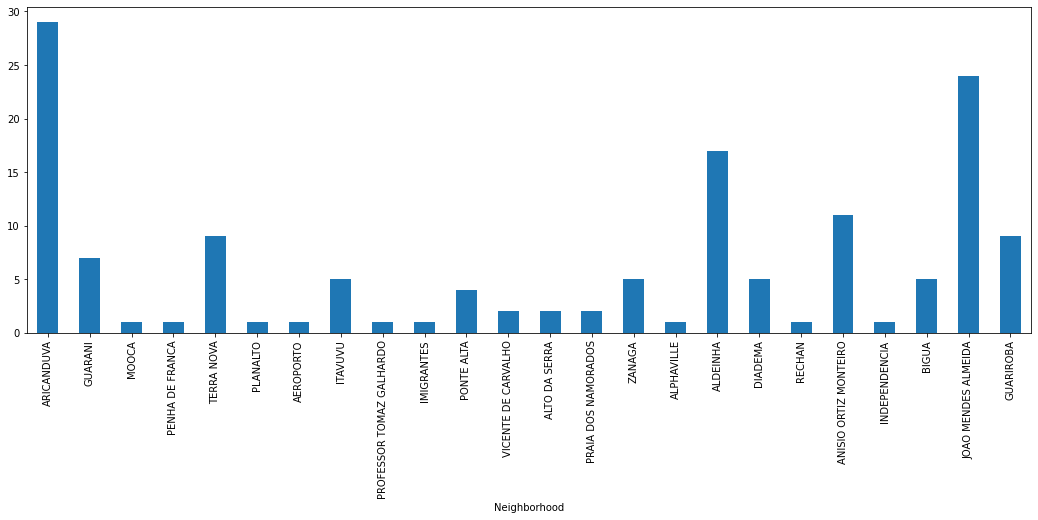

In [12]:
df = sp_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

The following plot shows only the neighborhoods from which 5 or more than 5 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

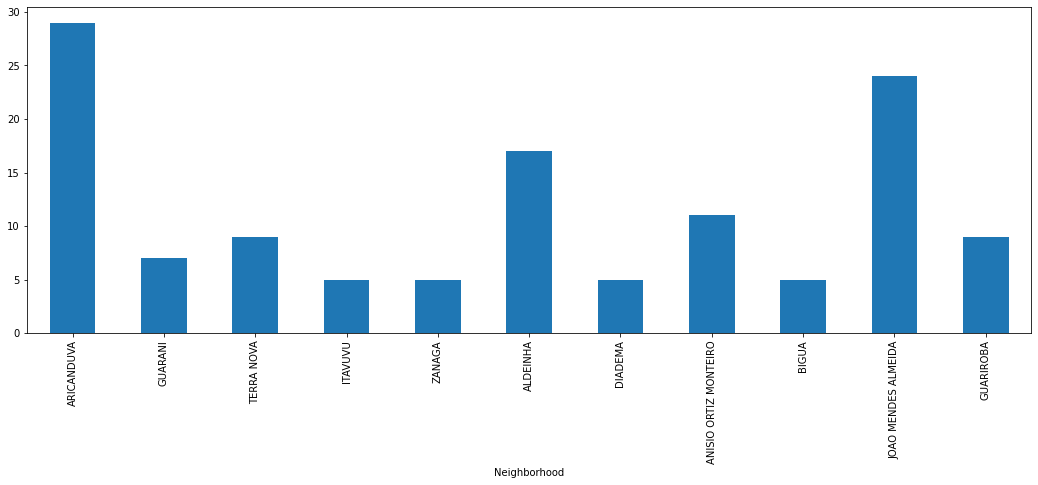

In [13]:
df = df[df >= 5]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, SP_top that contains only the neighborhoods with 10+ venues and the venues with their details included.

In [15]:
sp_venues_top = sp_venues[sp_venues['Neighborhood'].isin(df.index.tolist())]
sp_venues_top.head(100)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ARICANDUVA,-22.427500,-45.456944,O Mineirinho Bar,-22.427380,-45.454055,Bar
1,ARICANDUVA,-22.427500,-45.456944,Restaurante Sem Nome,-22.424986,-45.459393,Brazilian Restaurant
2,ARICANDUVA,-22.427500,-45.456944,Hotel Amamtykir,-22.427079,-45.461050,Hotel
3,ARICANDUVA,-22.427500,-45.456944,Bar do Noé,-22.428416,-45.454205,Brewery
4,ARICANDUVA,-22.427500,-45.456944,Mercado Municipal de Itajubá,-22.428093,-45.454076,Market
5,ARICANDUVA,-22.427500,-45.456944,Ilha Do Pastel,-22.426701,-45.456127,Fast Food Restaurant
6,ARICANDUVA,-22.427500,-45.456944,Queijaria do Mario,-22.423251,-45.457378,Restaurant
7,ARICANDUVA,-22.427500,-45.456944,Chalé Sonnenhof,-22.428105,-45.453975,Deli / Bodega
8,ARICANDUVA,-22.427500,-45.456944,Bar Cultural - D.A UNIFEI,-22.429980,-45.455527,Nightclub
9,ARICANDUVA,-22.427500,-45.456944,Taberna - Pirate Bar,-22.425468,-45.453348,Pub


#### Aux

In this step we will transpose into columns all occurrences and then group them all taking the mean value of the frequency of occurrence of each category.

In [16]:
sp_onehot = pd.get_dummies(sp_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sp_onehot['Neighborhood'] = sp_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = sp_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = sp_onehot.reindex(columns = fixed_columns)

print(sp_onehot.shape)
sp_onehot.head()

(126, 58)


,Arcade,Art Gallery,Bakery,Bar,Beach,Beer Garden,Beer Store,Brazilian Restaurant,Brewery,Burger Joint,Chocolate Shop,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Diner,Dive Bar,Electronics Store,Fast Food Restaurant,Food,Food & Drink Shop,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Market,Middle Eastern Restaurant,Nightclub,Park,Pastelaria,Peruvian Restaurant,Pharmacy,Pizza Place,Plaza,Pub,Residential Building (Apartment / Condo),Restaurant,Sandwich Place,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Steakhouse,Supermarket,Sushi Restaurant,Theater,Neighborhood
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ARICANDUVA
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ARICANDUVA
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ARICANDUVA
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ARICANDUVA
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ARICANDUVA


In [17]:
sp_grouped = sp_onehot.groupby('Neighborhood').mean().reset_index()
print(sp_grouped.shape)
sp_grouped.head()

(11, 58)


,Neighborhood,Arcade,Art Gallery,Bakery,Bar,Beach,Beer Garden,Beer Store,Brazilian Restaurant,Brewery,Burger Joint,Chocolate Shop,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Diner,Dive Bar,Electronics Store,Fast Food Restaurant,Food,Food & Drink Shop,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Market,Middle Eastern Restaurant,Nightclub,Park,Pastelaria,Peruvian Restaurant,Pharmacy,Pizza Place,Plaza,Pub,Residential Building (Apartment / Condo),Restaurant,Sandwich Place,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Steakhouse,Supermarket,Sushi Restaurant,Theater
0,ALDEINHA,0.0,0.0,0.058824,0.058824,0.000000,0.000000,0.058824,0.117647,0.000000,0.0,0.000000,0.000000,0.0,0.058824,0.0,0.0,0.0,0.000000,0.000000,0.058824,0.058824,0.0,0.000000,0.0,0.058824,0.000000,0.0,0.0,0.058824,0.000000,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.058824,0.0,0.0,0.058824,0.058824,0.000000,0.0,0.117647,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,ANISIO ORTIZ MONTEIRO,0.0,0.0,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.090909,0.0,0.0,0.000000,0.090909,0.090909,0.000000,0.000000,0.090909,0.090909,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.090909,0.000000,0.000000,0.0,0.090909,0.0,0.0,0.000000,0.000000,0.0,0.0,0.181818,0.000000,0.090909,0.0
2,ARICANDUVA,0.0,0.0,0.034483,0.068966,0.000000,0.034483,0.000000,0.137931,0.034483,0.0,0.034483,0.034483,0.0,0.000000,0.0,0.0,0.0,0.034483,0.034483,0.034483,0.000000,0.0,0.034483,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.034483,0.000000,0.103448,0.000000,0.034483,0.0,0.034483,0.034483,0.000000,0.0,0.0,0.000000,0.034483,0.034483,0.0,0.034483,0.0,0.0,0.034483,0.034483,0.0,0.0,0.034483,0.034483,0.000000,0.0
3,BIGUA,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.200000,0.200000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.2,0.000000,0.000000,0.000000,0.0
4,DIADEMA,0.0,0.0,0.200000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.200000,0.000000,0.000000,0.0,0.000000,0.2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


The following function returns the top_venues of each neighborhood

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe neighborhoods_venues_sorted.

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sp_grouped['Neighborhood']

for ind in np.arange(sp_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sp_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALDEINHA,Restaurant,Brazilian Restaurant,Diner,Construction & Landscaping,Pastelaria,Food & Drink Shop,Pizza Place,Plaza,Gym / Fitness Center,Gastropub
1,ANISIO ORTIZ MONTEIRO,Steakhouse,Grocery Store,French Restaurant,Ice Cream Shop,Beach,Sushi Restaurant,Golf Course,Pizza Place,Restaurant,Hotel
2,ARICANDUVA,Brazilian Restaurant,Hotel,Bar,Fast Food Restaurant,Department Store,Gym,Clothing Store,Market,Chocolate Shop,Nightclub
3,BIGUA,Gym / Fitness Center,Pizza Place,Soccer Stadium,Plaza,Grocery Store,Department Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Theater
4,DIADEMA,Brazilian Restaurant,Pizza Place,Bakery,Sandwich Place,Construction & Landscaping,Food & Drink Shop,Food,Fast Food Restaurant,Electronics Store,Dive Bar


#### Cluster Neighborhoods

Here k-Nearest Neighborhoods clustering technique is used. Lets use the silhouette_score to obtain the best value for the number of clusters.

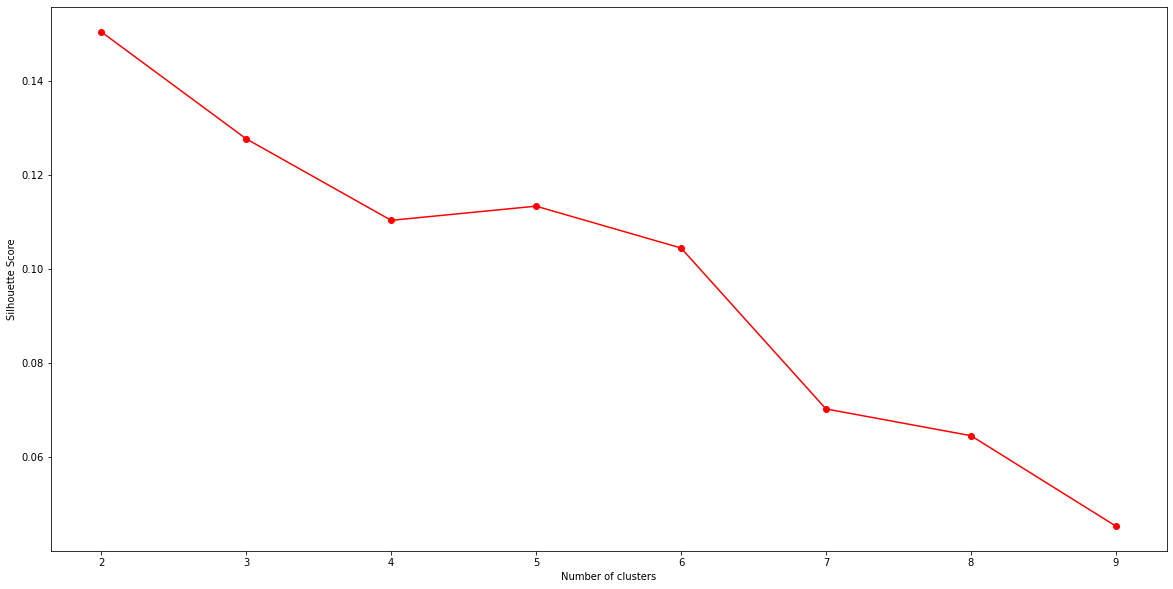

In [20]:
sp_grouped_clustering = sp_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(sp_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(sp_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

Lets consider the number of clusters as 5.

In [21]:
# select best number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sp_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 5, 4, 1, 2, 1, 1])

Lets add the labels and create a new dataframe containing all details and the 10 most common venues in that neighborhood.

In [22]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sp_merged = sp_venues_top[sp_venues_top.columns[0:3]].drop_duplicates()
sp_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sp_merged = sp_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sp_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ARICANDUVA,-22.427500,-45.456944,1,Brazilian Restaurant,Hotel,Bar,Fast Food Restaurant,Department Store,Gym,Clothing Store,Market,Chocolate Shop,Nightclub
1,GUARANI,-22.417778,-45.447500,4,Pizza Place,Market,Brewery,Burger Joint,Coffee Shop,Convenience Store,Food & Drink Shop,Food,Fast Food Restaurant,Electronics Store
2,TERRA NOVA,-22.735278,-45.126389,1,Bar,Theater,Fast Food Restaurant,Burger Joint,Electronics Store,Brazilian Restaurant,Shop & Service,Bakery,Food,Cosmetics Shop
3,ITAVUVU,-22.609444,-46.526389,2,Beer Store,Furniture / Home Store,Snack Place,Brewery,Restaurant,Diner,Dance Studio,Deli / Bodega,Department Store,Theater
4,ZANAGA,-21.292778,-46.703056,3,Restaurant,Hotel,Brazilian Restaurant,Cosmetics Shop,Theater,Convenience Store,Food & Drink Shop,Food,Fast Food Restaurant,Electronics Store


### Results

Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. 

For this purpose lets also print the ten most common venue category in each cluster.

#### Cluster 1

In [53]:
sp_merged.loc[sp_merged['Cluster Labels'] == 0, sp_merged.columns[[0] + list(range(4, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,BIGUA,Gym / Fitness Center,Pizza Place,Soccer Stadium,Plaza,Grocery Store,Department Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Theater


In [54]:
cluster1 = sp_merged.loc[sp_merged['Cluster Labels'] == 0, sp_merged.columns[[0] + 
                                                                                    list(range(4, sp_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Deli / Bodega           1
Plaza                   1
Grocery Store           1
Theater                 1
Cosmetics Shop          1
Dance Studio            1
Gym / Fitness Center    1
Department Store        1
Soccer Stadium          1
Pizza Place             1
dtype: int64


#### Cluster 2

In [55]:
sp_merged.loc[sp_merged['Cluster Labels'] == 1, sp_merged.columns[[0] + list(range(4, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ARICANDUVA,Brazilian Restaurant,Hotel,Bar,Fast Food Restaurant,Department Store,Gym,Clothing Store,Market,Chocolate Shop,Nightclub
2,TERRA NOVA,Bar,Theater,Fast Food Restaurant,Burger Joint,Electronics Store,Brazilian Restaurant,Shop & Service,Bakery,Food,Cosmetics Shop
5,ALDEINHA,Restaurant,Brazilian Restaurant,Diner,Construction & Landscaping,Pastelaria,Food & Drink Shop,Pizza Place,Plaza,Gym / Fitness Center,Gastropub
7,ANISIO ORTIZ MONTEIRO,Steakhouse,Grocery Store,French Restaurant,Ice Cream Shop,Beach,Sushi Restaurant,Golf Course,Pizza Place,Restaurant,Hotel
9,JOAO MENDES ALMEIDA,Pizza Place,Dance Studio,Art Gallery,Soccer Field,Pharmacy,Arcade,Gym,Middle Eastern Restaurant,Nightclub,Grocery Store
10,GUARIROBA,Gym / Fitness Center,Gas Station,Food,Bar,Snack Place,Convenience Store,Restaurant,Market,Theater,Department Store


In [56]:
cluster2 = sp_merged.loc[sp_merged['Cluster Labels'] == 1, sp_merged.columns[[0] + 
                                                                                    list(range(4, sp_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Pizza Place             3
Bar                     3
Brazilian Restaurant    3
Restaurant              3
Grocery Store           2
Gym                     2
Gym / Fitness Center    2
Department Store        2
Fast Food Restaurant    2
Theater                 2
dtype: int64


#### Cluster 3

In [57]:
sp_merged.loc[sp_merged['Cluster Labels'] == 2, sp_merged.columns[[0] + list(range(4, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,ITAVUVU,Beer Store,Furniture / Home Store,Snack Place,Brewery,Restaurant,Diner,Dance Studio,Deli / Bodega,Department Store,Theater


In [58]:
cluster3 = sp_merged.loc[sp_merged['Cluster Labels'] == 2, sp_merged.columns[[0] + 
                                                                                    list(range(4, sp_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Brewery                   1
Beer Store                1
Theater                   1
Snack Place               1
Dance Studio              1
Department Store          1
Deli / Bodega             1
Furniture / Home Store    1
Diner                     1
Restaurant                1
dtype: int64


#### Cluster 4

In [59]:
sp_merged.loc[sp_merged['Cluster Labels'] == 3, sp_merged.columns[[0] + list(range(4, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,ZANAGA,Restaurant,Hotel,Brazilian Restaurant,Cosmetics Shop,Theater,Convenience Store,Food & Drink Shop,Food,Fast Food Restaurant,Electronics Store


In [60]:
cluster4 = sp_merged.loc[sp_merged['Cluster Labels'] == 3, sp_merged.columns[[0] + 
                                                                                    list(range(4, sp_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Convenience Store       1
Food & Drink Shop       1
Fast Food Restaurant    1
Hotel                   1
Theater                 1
Cosmetics Shop          1
Brazilian Restaurant    1
Electronics Store       1
Food                    1
Restaurant              1
dtype: int64


#### Cluster 5

In [61]:
sp_merged.loc[sp_merged['Cluster Labels'] == 4, sp_merged.columns[[0] + list(range(4, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,GUARANI,Pizza Place,Market,Brewery,Burger Joint,Coffee Shop,Convenience Store,Food & Drink Shop,Food,Fast Food Restaurant,Electronics Store


In [62]:
cluster5 = sp_merged.loc[sp_merged['Cluster Labels'] == 4, sp_merged.columns[[0] + 
                                                                                    list(range(4, sp_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Convenience Store       1
Food & Drink Shop       1
Coffee Shop             1
Market                  1
Fast Food Restaurant    1
Pizza Place             1
Electronics Store       1
Food                    1
Burger Joint            1
Brewery                 1
dtype: int64


#### Cluster 6

In [63]:
sp_merged.loc[sp_merged['Cluster Labels'] == 5, sp_merged.columns[[0] + list(range(4, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,DIADEMA,Brazilian Restaurant,Pizza Place,Bakery,Sandwich Place,Construction & Landscaping,Food & Drink Shop,Food,Fast Food Restaurant,Electronics Store,Dive Bar


In [64]:
cluster6 = sp_merged.loc[sp_merged['Cluster Labels'] == 5, sp_merged.columns[[0] + 
                                                                                    list(range(4, sp_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Food & Drink Shop             1
Construction & Landscaping    1
Bakery                        1
Food                          1
Fast Food Restaurant          1
Pizza Place                   1
Brazilian Restaurant          1
Sandwich Place                1
Electronics Store             1
Dive Bar                      1
dtype: int64


### Understanding the Clusters 

Lets visulaize the top 5 most common venue categories in each of the cluster.

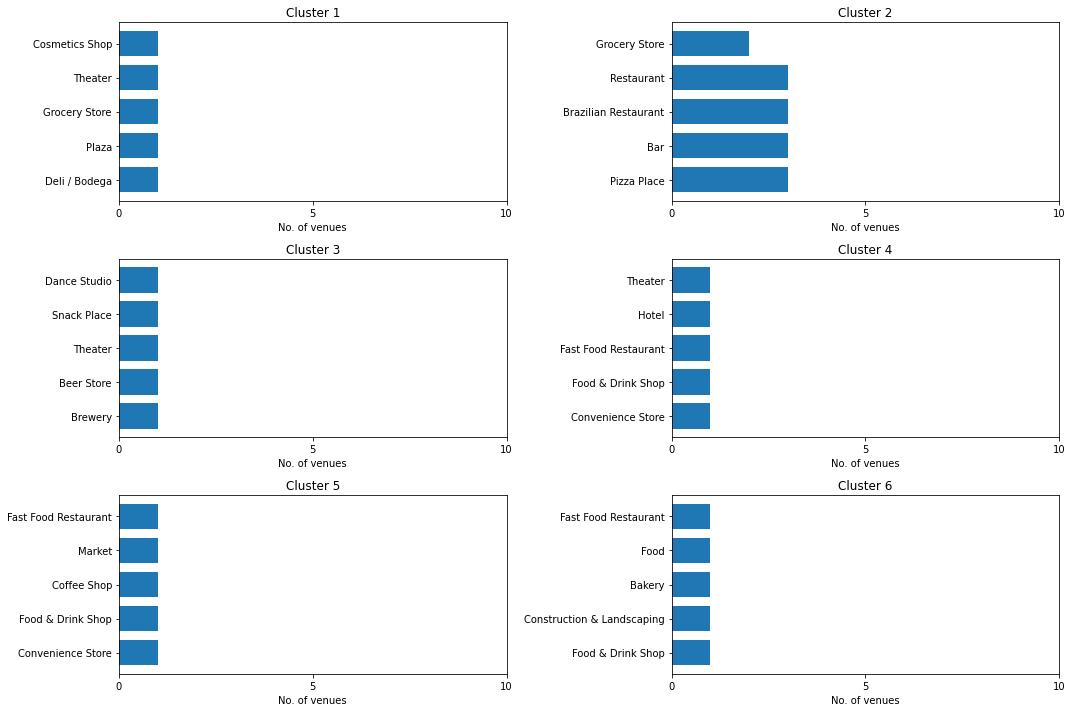

In [79]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6]
fig, axes = plt.subplots(3, 2)

count = 0
for r in range(3):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.75, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

All plots presented above can be used to suggest valuable information to Business persons. Let's discuss a few examples.

Lets supose that the intention is open a new Hotel. As we can see the cluster 4 is where we have more Hotel, so this Cluster is not the best choice to open another one. Otherwise, the others clusters does not have Hotels.
It does not mean that all these clusters are good to open one. From my understanding, every Hotel needs to be well located, in other words it means that Hotels needs Restaurants, Coffee Shops and this kind of store around. 
So, based on that, we can concluded that the Cluster5 its the best option once we have Market, Restaurant, Coffee Shop and others.

#### Map of Sao Paulo with the clusters superimposed on top

In [82]:
# create map
sp_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sp_merged['Neighborhood Latitude'], sp_merged['Neighborhood Longitude'], sp_merged['Neighborhood'], sp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(sp_clusters_map)
       
sp_clusters_map

This map can also be used to select a vast suggestion area for a particular type of business based on the category.

### Conclusion 

The purpose here in this project (Capstone - The Battle of Neighborhoods) was to analyze the neighborhoods of state of Sao Paulo and create a clustering model to suggest the best location to start a new business. All the data was obtained from an online source (Anatel) and from the Foursquare API that was used to find the major venues in each neighborhood.

But we found that a considerable numbers of neighborhoods had less than 5 venues returned. So, in order to build a good Data Science model, these locations were all removed. Thus, the remaining locations were used to create the clustering model. The best number of clusters (5) was obtained using the silhouette score. cluster.

One exemple was presented (Hotel) and a map showing the clusters have been showed. It is important to mention that both these can be used by stakeholders or investors to decide the location for the new business desired.

##### Kind regards, William Roesch